good definition of |g|

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import galsim
import scipy.stats as stats
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import scipy

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot, generator, results_processing, boxplot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_alpha, denorm, delta_min, norm, load_vae_full
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, plot_rgb, createCircularMask, mean_var, plot_corner_latent, scatter_galaxies
from tools_for_VAE.results_processing import processing
from tools_for_VAE.boxplot import boxplot_func

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Function to import deblender

In [11]:
deblender_lsst,deblender_utils_lsst, encoder_lsst, decoder_lsst, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v9_mis/mse/', #7/bis
                                                                                     6, folder = True)#6/train_6  #7 (PReLu pas sur echantillons 28)

In [48]:
deblender_lsst_euclid,deblender_utils_lsst_euclid, encoder_lsst_euclid, decoder_lsst_euclid, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST_EUCLID/deblender/v9_mis/mse/',#6/bis_bis
                                                                                            10, folder = True)#5/train_7  #6 (PReLu pas sur echantillons 28)

# Fix parameters

In [6]:
# Batch size for training
batch_size = 100

# Physical stamp size
phys_stamp_size_euclid = 6.4 # arcsec for VIS Euclid instrument
phys_stamp_size_lsst = 3.2 # arcsec for LSST instrument

# Pixel scales
pixel_scale_euclid_vis = 0.1 # arcsec/pixel
pixel_scale_lsst = 0.2

# Stamp size used
stamp_size = int(phys_stamp_size_euclid/pixel_scale_euclid_vis)

# Load test data

Load shifts and images

In [55]:
data_dir = '/sps/lsst/users/barcelin/data/blended_images/28/miscenter_19112019/test/'
root = 'galaxies_blended_20191024'

In [56]:
shifts = np.load(os.path.join(data_dir, root+'_0_shifts.npy'))

In [57]:
images = np.load(data_dir+'galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
test_sample = [data_dir+'galaxies_blended_20191024_0_images.npy']

Load rest of test data

In [58]:
dfs = []

#dfs.append(pd.read_csv(os.path.join(data_dir, root+'_010_data.csv')))
dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
nb_blended_gal                10000 non-null int64
SNR                           10000 non-null float64
SNR_peak                      10000 non-null float64
redshift                      10000 non-null float64
moment_sigma                  10000 non-null float64
e1                            10000 non-null float64
e2                            10000 non-null float64
mag                           10000 non-null float64
mag_ir                        10000 non-null float64
closest_x                     10000 non-null float64
closest_y                     10000 non-null float64
closest_redshift              10000 non-null float64
closest_moment_sigma          10000 non-null float64
closest_e1                    10000 non-null float64
closest_e2                    10000 non-null float64
closest_mag                   10000 non-null float64
closest_mag_ir                10000 non-null f

In [60]:
df.describe()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_aperture_lsst,blendedness_total_euclid,blendedness_closest_lsst,blendedness_closest_euclid
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,7404.000000,7404.000000,7404.000000,7404.000000,7404.000000
mean,2.486000,254.825145,0.183333,0.934204,2.155757,-0.003080,-0.003238,26.097345,-1.896870,-0.003670,...,1.926814,0.002988,-0.002192,27.282364,-1.195149,0.152132,0.099212,0.091318,0.364263,0.135961
std,1.123802,523.676457,0.451737,0.713626,0.527992,0.283918,0.285459,1.444426,1.373245,0.573522,...,0.370222,0.303080,0.301447,1.005281,1.227471,0.122807,0.109292,0.119070,0.221231,0.150559
min,1.000000,3.023722,0.001945,0.006500,1.488475,-1.462437,-1.324154,20.037094,-7.306114,-1.568639,...,1.488475,-1.481956,-1.433884,20.448996,-6.996996,0.000226,0.000022,0.000025,0.018603,0.000209
25%,1.000000,51.656231,0.037045,0.428400,1.786956,-0.168953,-0.170879,25.368813,-2.758874,-0.355131,...,1.683555,-0.187099,-0.193819,26.872760,-1.876931,0.050334,0.017676,0.011208,0.171534,0.020328
50%,2.000000,94.984019,0.065414,0.741800,2.023886,-0.002311,-0.005232,26.383874,-1.737430,0.001052,...,1.826883,0.001570,-0.006836,27.443343,-0.984893,0.121515,0.058329,0.042615,0.337031,0.075577
75%,3.000000,204.531255,0.135926,1.162600,2.358661,0.161860,0.169804,27.097584,-0.903616,0.354939,...,2.052596,0.193939,0.185678,27.873527,-0.293574,0.227785,0.146269,0.125754,0.541103,0.207371
max,4.000000,6821.537044,8.076227,5.208000,5.651824,1.436320,1.261928,29.684309,0.930522,1.566238,...,5.651823,1.707955,1.499976,29.792827,0.946252,0.698916,0.742302,0.844293,0.909215,0.839920


29.68430936221137

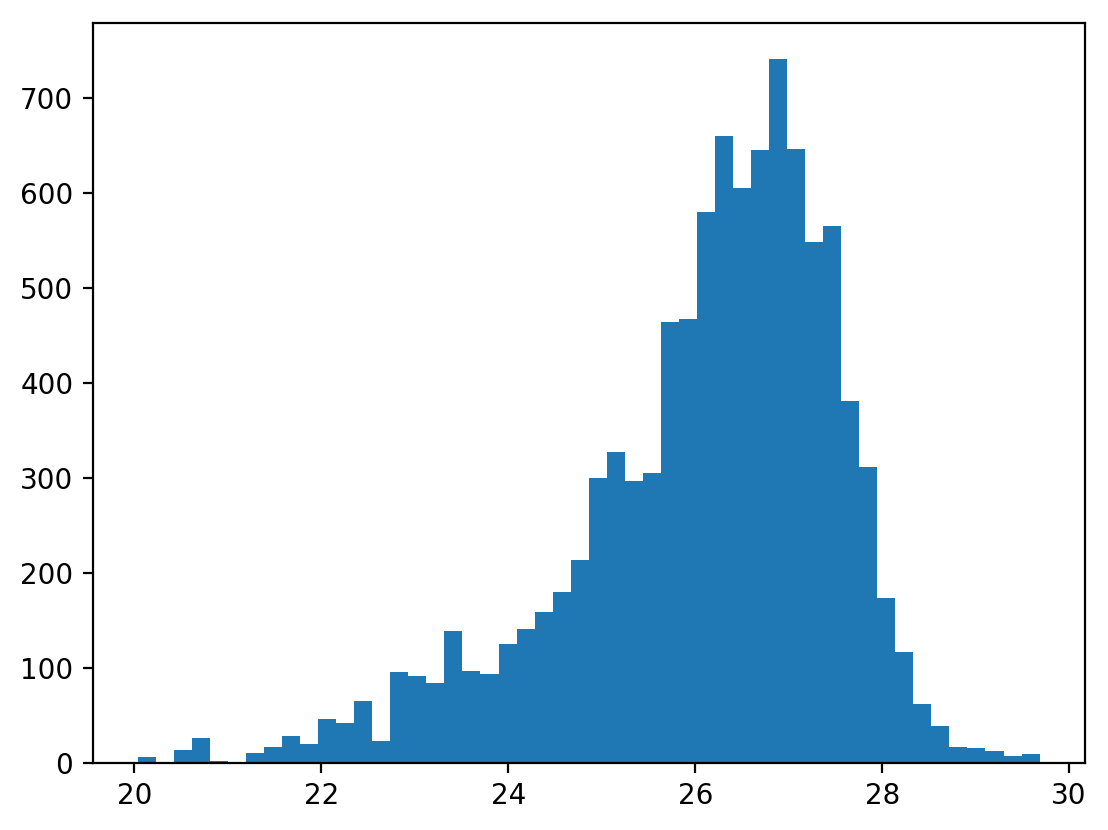

In [61]:
_ = plt.hist(df['mag'], bins = 50)
np.max(df['mag'])

# Parameters

In [16]:
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

psf = galsim.Kolmogorov(fwhm=0.65)
pix_scale_lsst = 0.2

batch_size = 100
stamp_size = 64

n_years = 5

# LSST only

## Shape reproduction

In [37]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [38]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [49]:
df_lsst = results_processing.processing(deblender_lsst,
                                  data_dir,
                                  root,
                                  test_sample[0],
                                  bands_lsst,
                                  2,
                                  stamp_size,
                                  batch_size,
                                  psf,
                                  pix_scale_lsst,
                                  n_years)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
error for galaxy 12023
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
error for galaxy 28833
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99

(10000, 2, 2)


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
nb_blended_gal               10000 non-null int64
SNR                          10000 non-null float64
SNR_peak                     10000 non-null float64
redshift                     10000 non-null float64
moment_sigma                 10000 non-null float64
e1                           10000 non-null float64
e2                           10000 non-null float64
mag                          10000 non-null float64
mag_ir                       10000 non-null float64
closest_x                    7591 non-null float64
closest_y                    7591 non-null float64
closest_redshift             7591 non-null float64
closest_moment_sigma         7591 non-null float64
closest_e1                   7591 non-null float64
closest_e2                   7591 non-null float64
closest_mag                  7591 non-null float64
closest_mag_ir               7591 non-null float64
blendedness_total_

In [126]:
df.describe()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,blendedness_closest_lsst,blendedness_closest_euclid,e1_in,e1_out,e2_in,e2_out,e_in,e_out,mag_in,mag_out
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,6927.000000,6927.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.326800,120.542613,0.184105,0.923295,2.175666,0.003445,-0.001777,25.974744,-1.951157,-0.002958,...,0.539313,0.269388,0.003445,0.001631,-0.001777,-0.006408,0.329521,0.302307,25.975286,25.985426
std,1.111002,237.650885,0.428907,0.733529,0.533526,0.278100,0.278661,1.404586,1.374391,0.404644,...,0.232039,0.234183,0.278100,0.258402,0.278661,0.262197,0.215433,0.210152,1.401905,1.395050
min,1.000000,6.343976,0.006464,0.006500,1.488476,-1.564115,-1.397318,20.037094,-7.306114,-0.999368,...,0.023587,0.000245,-1.564115,-2.538030,-1.397318,-4.932887,0.004438,0.001718,20.098586,20.314331
25%,1.000000,25.346898,0.038478,0.405900,1.804618,-0.156923,-0.157973,25.240076,-2.837569,-0.202946,...,0.345620,0.072935,-0.156923,-0.143555,-0.157973,-0.145506,0.160446,0.147849,25.238726,25.262057
50%,2.000000,45.650881,0.067025,0.718750,2.042732,0.001054,0.002363,26.283262,-1.765570,0.000000,...,0.542005,0.197978,0.001054,-0.000934,0.002363,-0.002883,0.288477,0.259882,26.283154,26.290369
75%,3.000000,97.979607,0.141105,1.139800,2.394902,0.160726,0.157897,27.013120,-0.958320,0.196136,...,0.729688,0.418673,0.160726,0.146028,0.157897,0.137615,0.459258,0.411675,27.012086,27.014606
max,4.000000,3050.680684,7.746850,5.208000,5.651824,1.465109,1.434683,27.996072,0.946252,0.999947,...,0.997504,0.988586,1.465109,1.376316,1.434683,2.010638,1.571839,4.980213,28.073968,28.417881


In [117]:
df_lsst.to_csv('data/df_deb_lsst_miscenter_2.csv')

In [62]:
df_lsst = pd.read_csv('data/df_deb_lsst_miscenter_2.csv', encoding = 'utf-8')

Plots

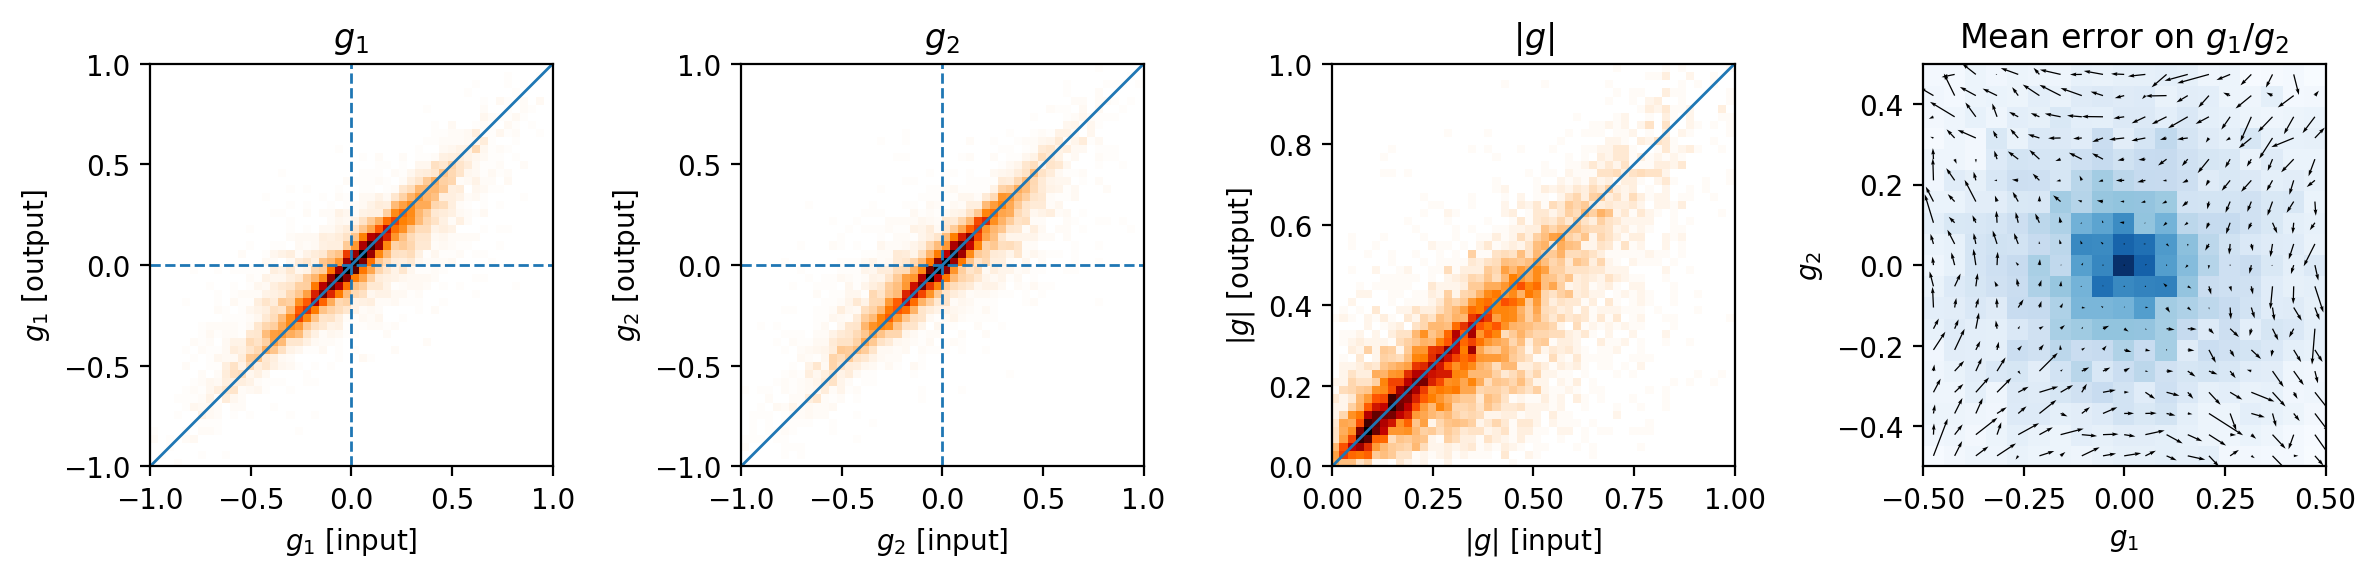

In [50]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst['e1_in'], df_lsst['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst['e2_in'], df_lsst['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst['e_in'], df_lsst['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst['e1_in'], df_lsst['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

# LSST + Euclid

## Shape reproduction

In [12]:
df_lsst_euclid = results_processing.processing(deblender_lsst_euclid,
                                               data_dir,
                                               root,
                                              test_sample[0],
                                              bands_lsst_euclid,
                                              6,
                                              stamp_size,
                                              batch_size,
                                              psf,
                                              pix_scale_lsst,
                                              n_years)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99

(10000, 2, 2)


In [13]:
df_lsst_euclid.to_csv('data/df_deblender_lsst_euclid_miscenter.csv')

In [14]:
df_lsst_euclid = pd.read_csv('data/df_deblender_lsst_euclid_miscenter.csv', encoding = 'utf-8')

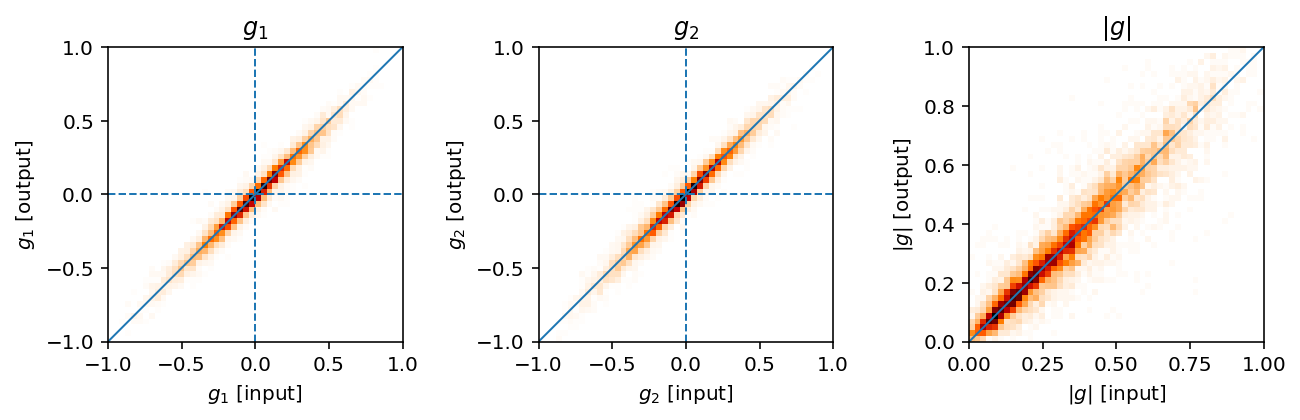

In [15]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e2_in'], df_lsst_euclid['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e_in'], df_lsst_euclid['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')


plt.tight_layout()

## Flux reproduction

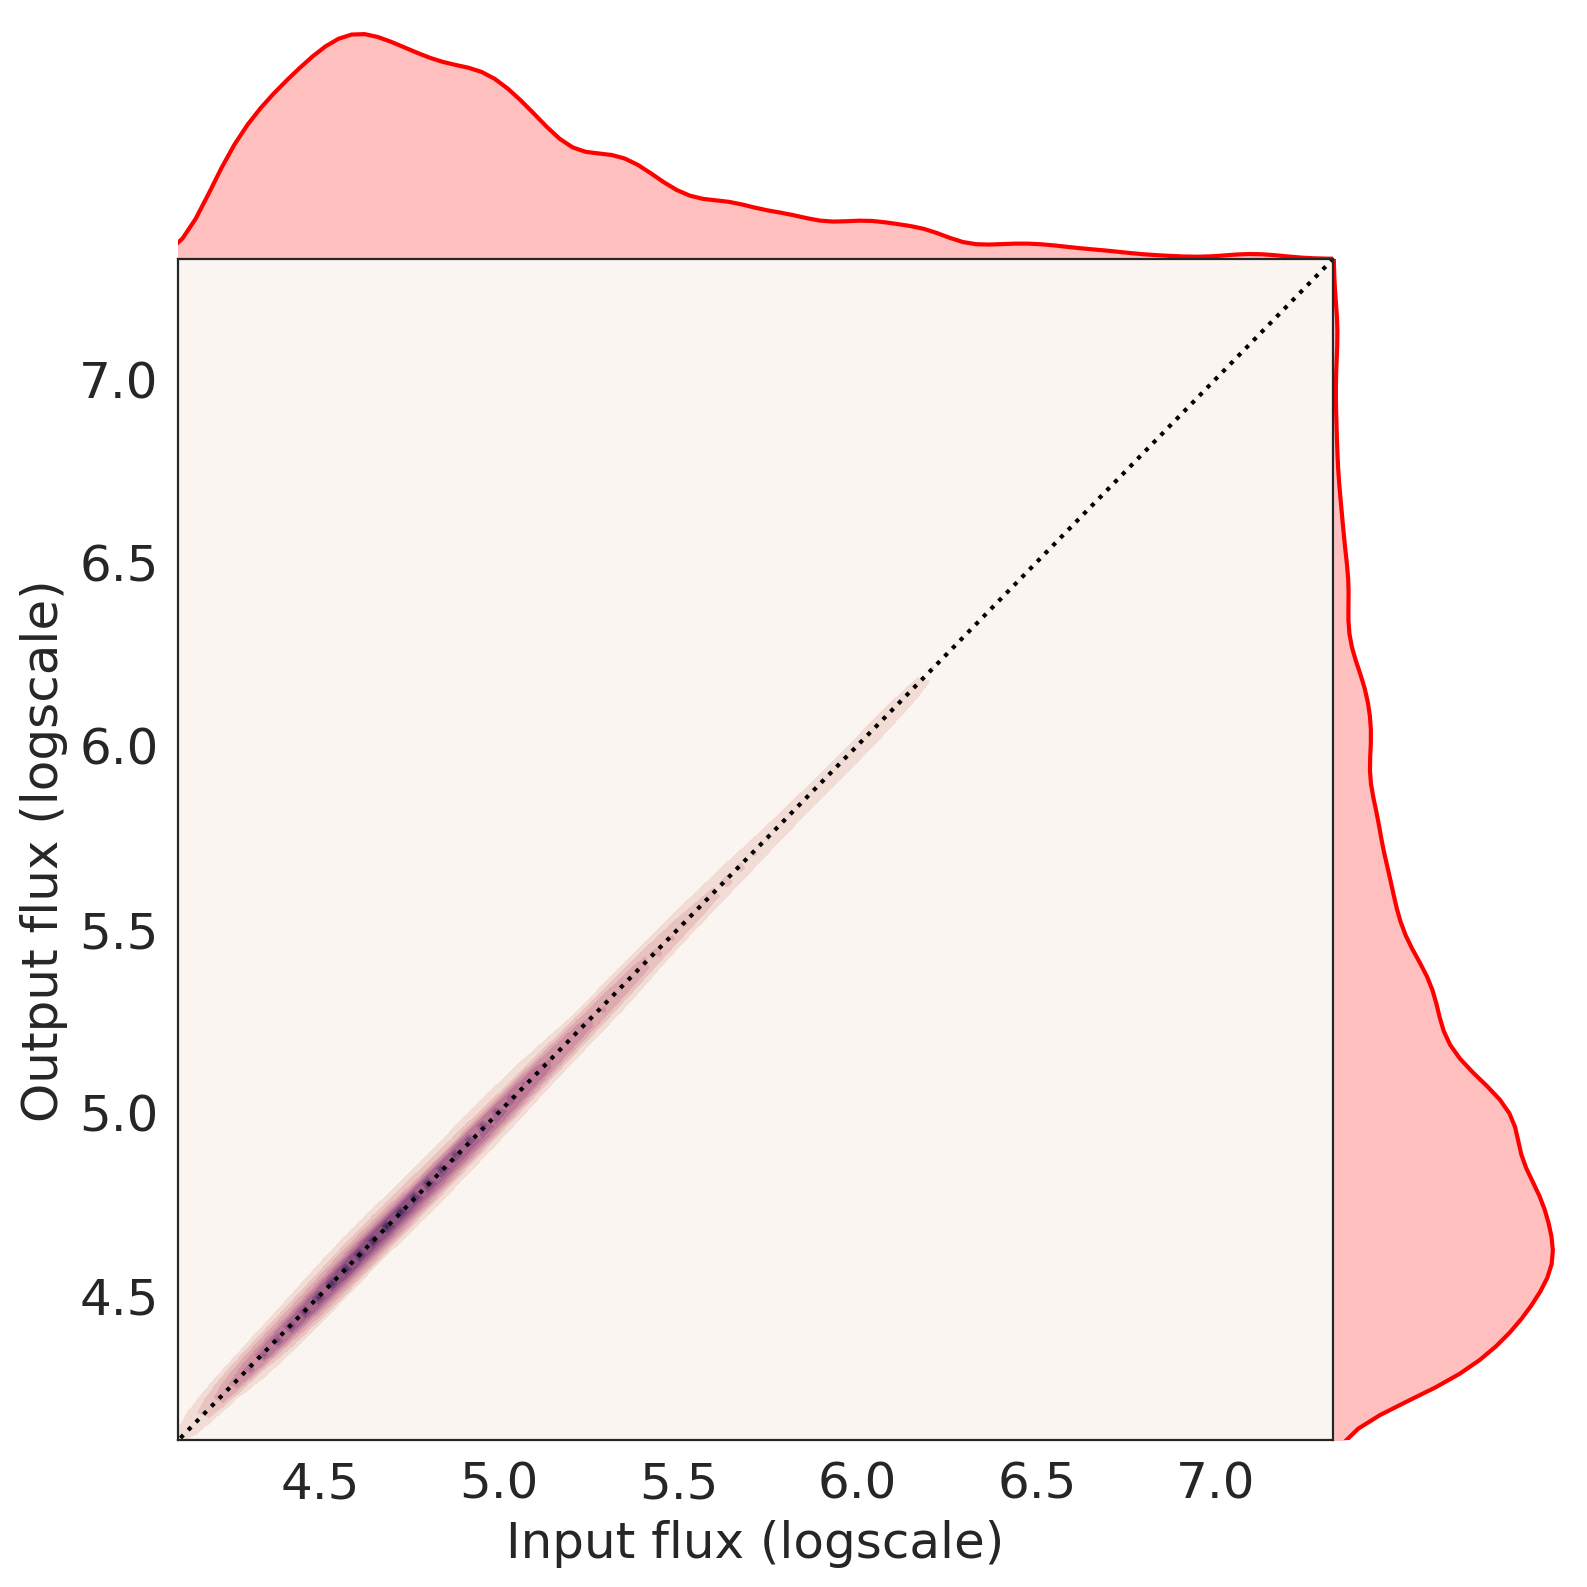

In [200]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst_euclid), np.log10(flux_out_lsst_euclid), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))], ylim=[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))), ':k')

# Delta WL parameters

## As function of SNR

In [51]:
df_plot = pd.concat([df_lsst], ignore_index=True)#df_lsst_euclid_center,
df_plot['exp'] = [1]*10000# + [2]*10000

### Error on ellipticity

In [52]:
np.min(df_plot['SNR'])

6.385787914810907

7589
[1]
0 1


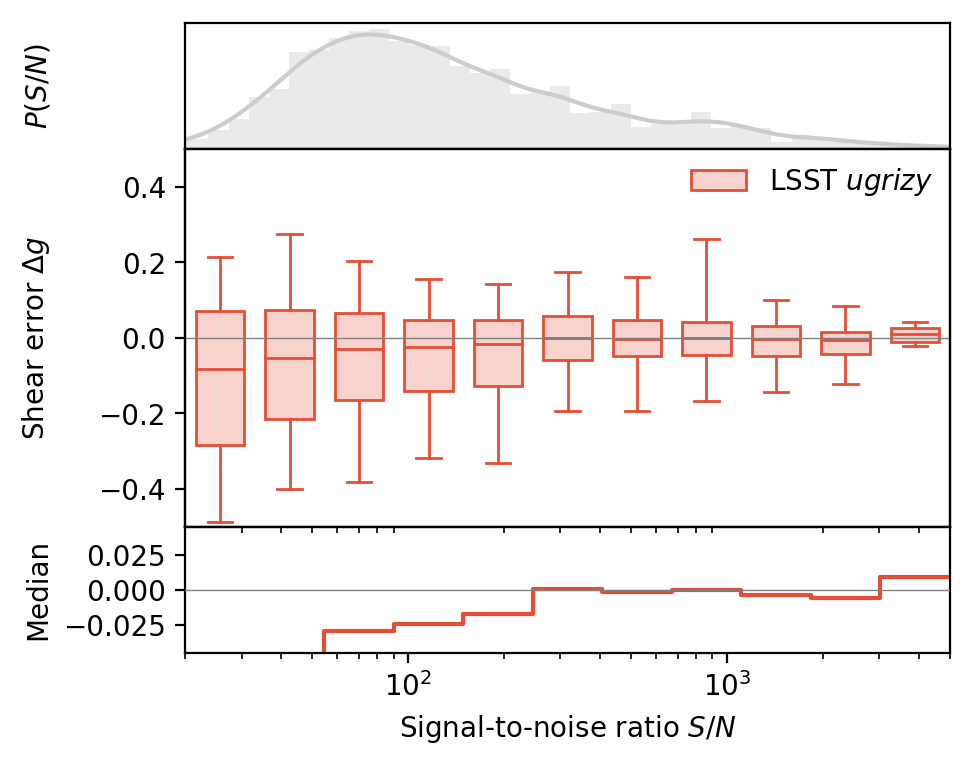

In [53]:
fig = boxplot.boxplot_func(df_plot, x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (20, 5000),
              ylim = (-0.5, 0.5), 
              ylim2= (-0.045, 0.045),
              x_scale = 'log',
              legend = ['LSST $ugrizy$'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Shear error $\\Delta g$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'Median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.15]),#0.85,
              nbins = 11)

#fig.savefig('figures/e_snr.pdf')

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


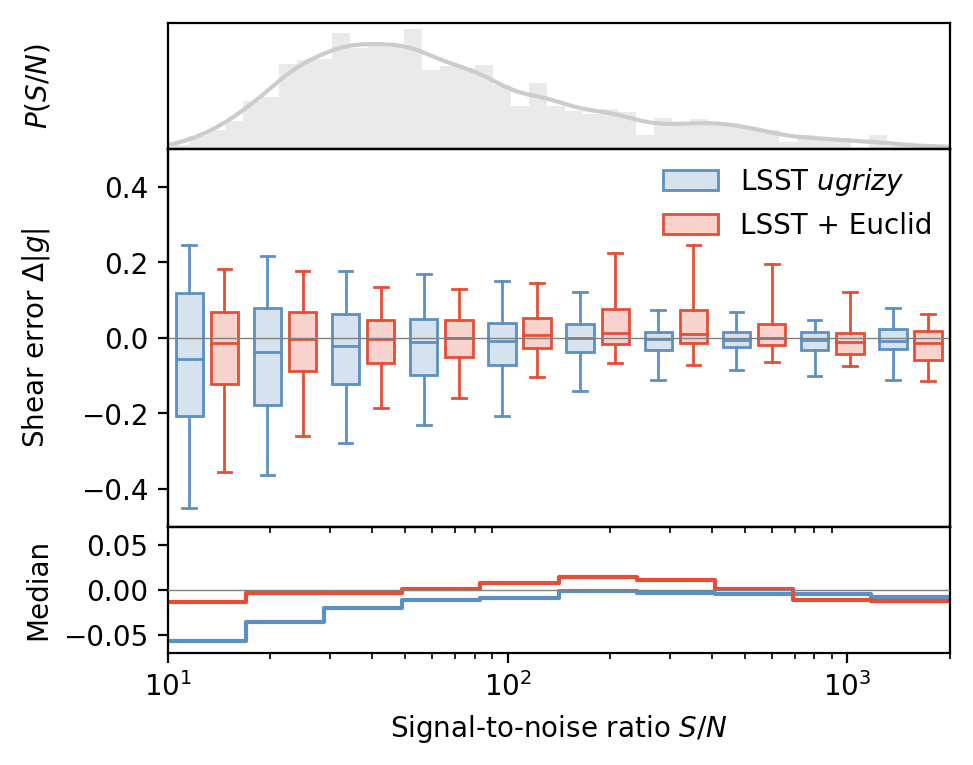

In [94]:
fig = boxplot(df_plot, x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (10, 2000),
              ylim = (-0.5, 0.5),
              ylim2= (-0.07, 0.07),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'Median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_snr_2.pdf')

Magnitude error as function of S/N

7589
[1]
0 1


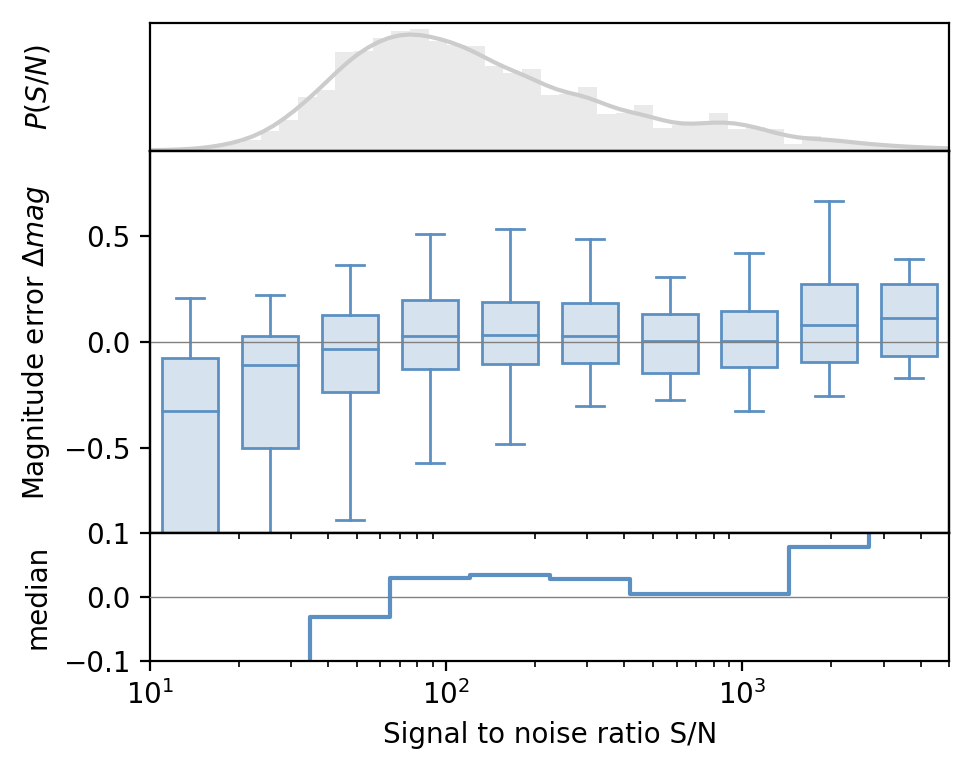

In [54]:
fig = boxplot_func(df_plot, x = 'SNR', y = 'delta_mag', z = 'exp',
              xlim = (10, 5000),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'log',
              legend = ['LSST $ugrizy$'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig[0].savefig('figures/mag_snr_2.pdf')

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


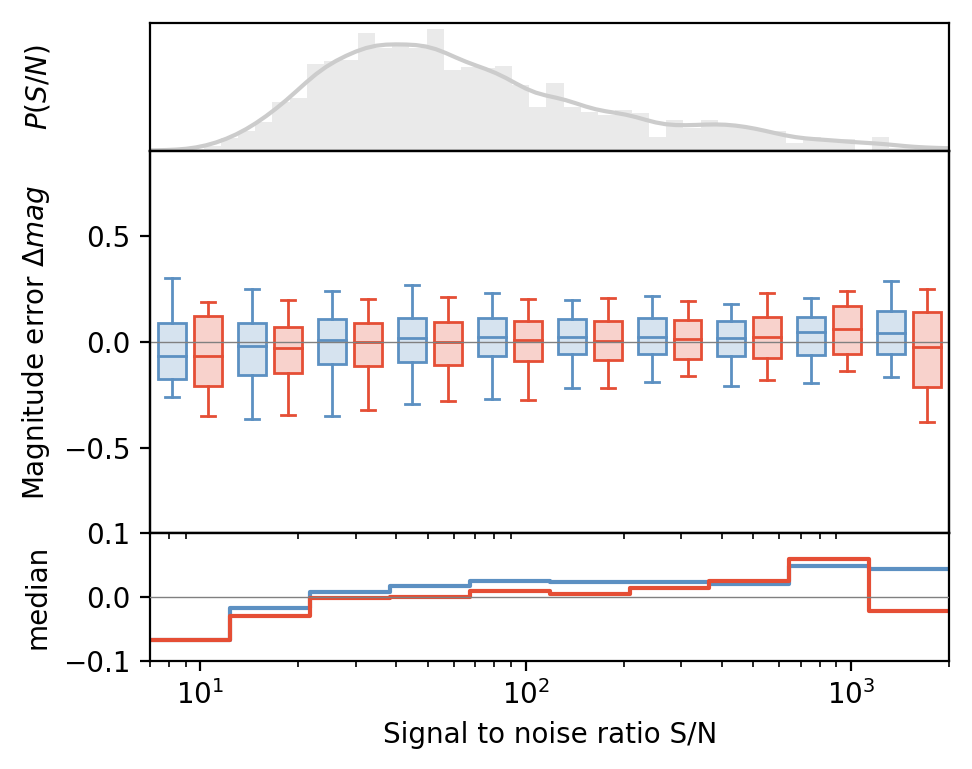

In [96]:
fig = boxplot(df_plot, x = 'SNR', y = 'mag_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_snr_2.pdf')

### Error on flux

In [76]:
np.max(df_plot['mag'])

27.996071897478828

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


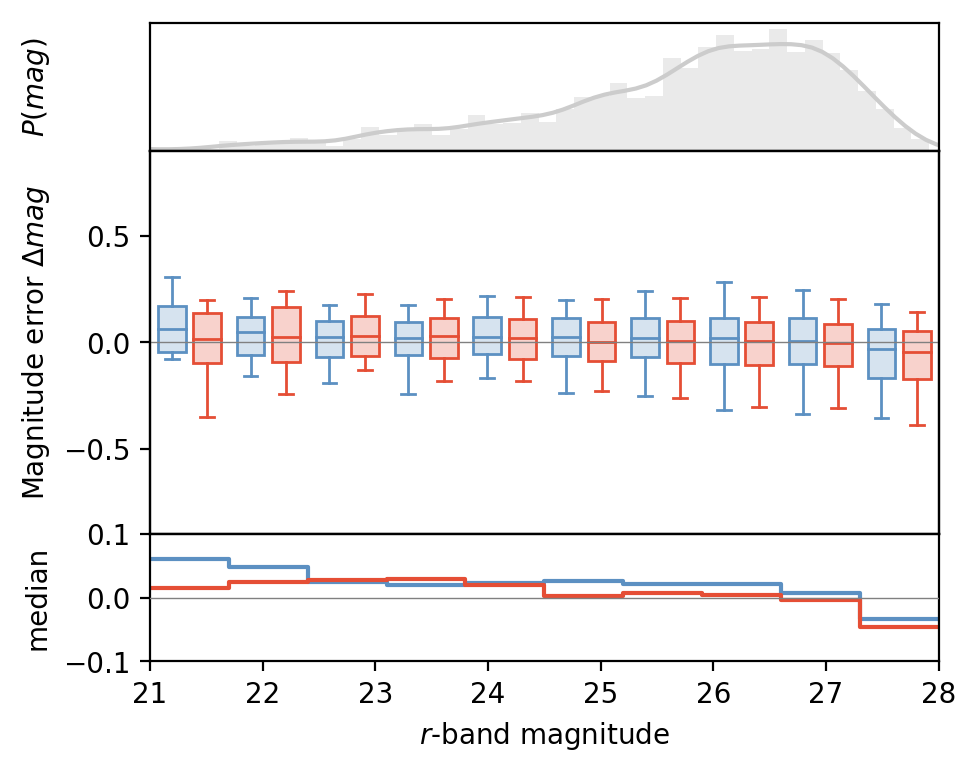

In [97]:
fig = boxplot(df_plot, x = 'mag', y = 'mag_error', z = 'exp',
              xlim = (21., 28.),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$r$-band magnitude', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_mag_2.pdf')

## As a function of blend rate

### As a function of blend rate with closest

#### Error on ellipticity

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


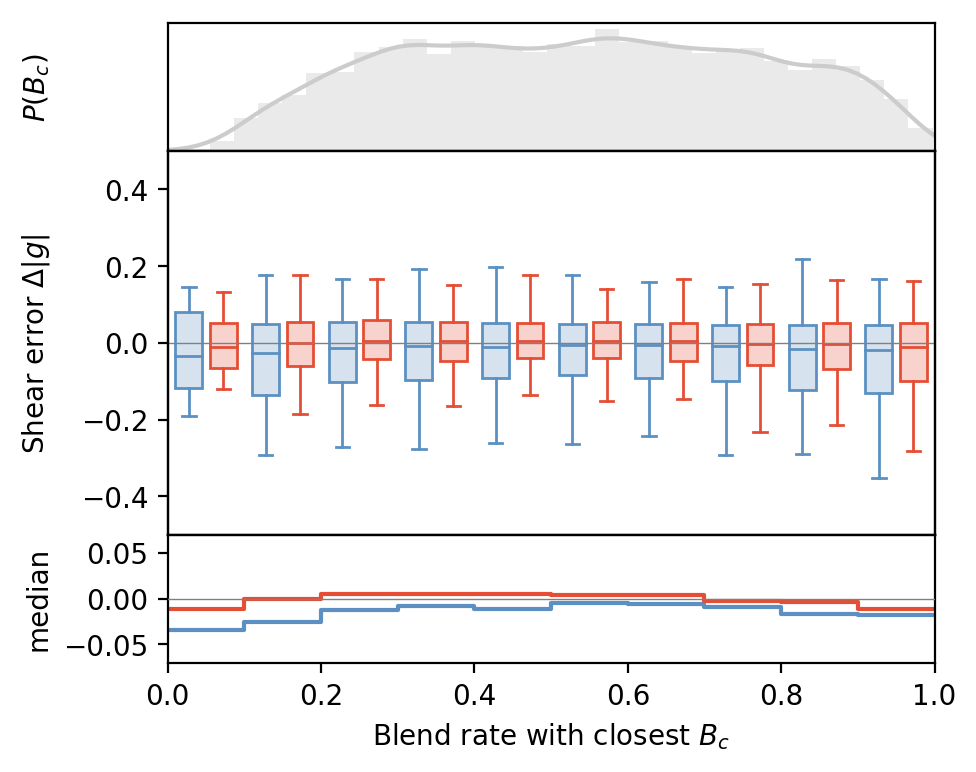

In [98]:
fig = boxplot(df_plot, x = 'blendedness_closest_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 1.),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blend rate with closest $B_c$', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_b_c_2.pdf')

#### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


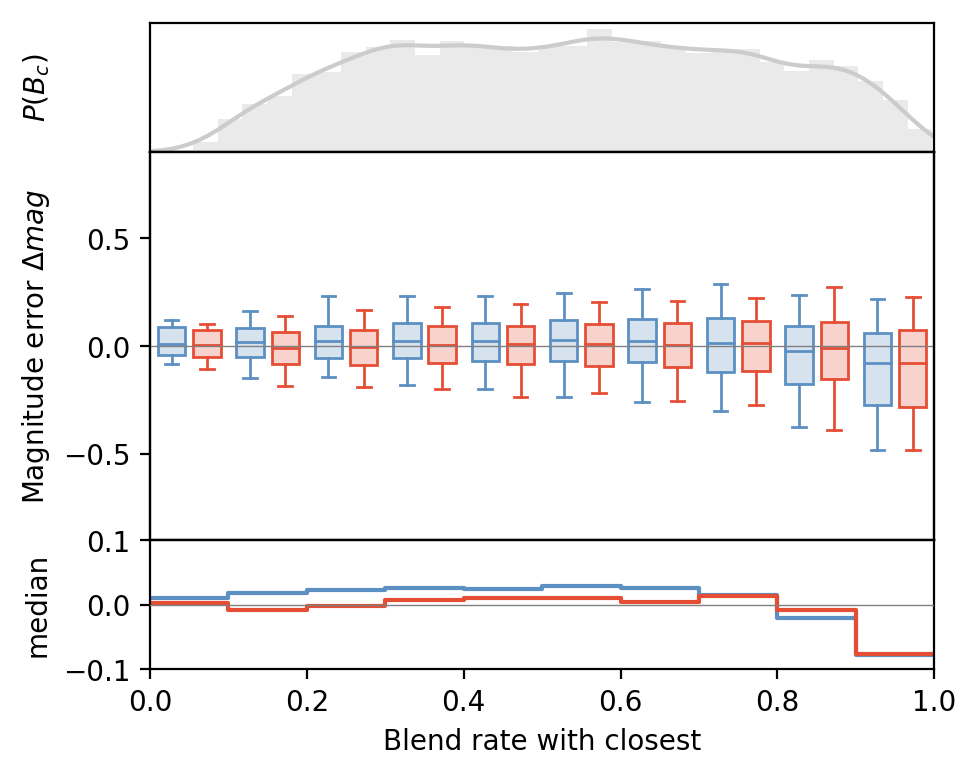

In [99]:
fig = boxplot(df_plot, x = 'blendedness_closest_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., 1.),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blend rate with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_c_2.pdf')

### As a function of total blend rate

#### Error on ellipticity

In [53]:
np.max(df['blendedness_total_lsst'])

0.764361172914505

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


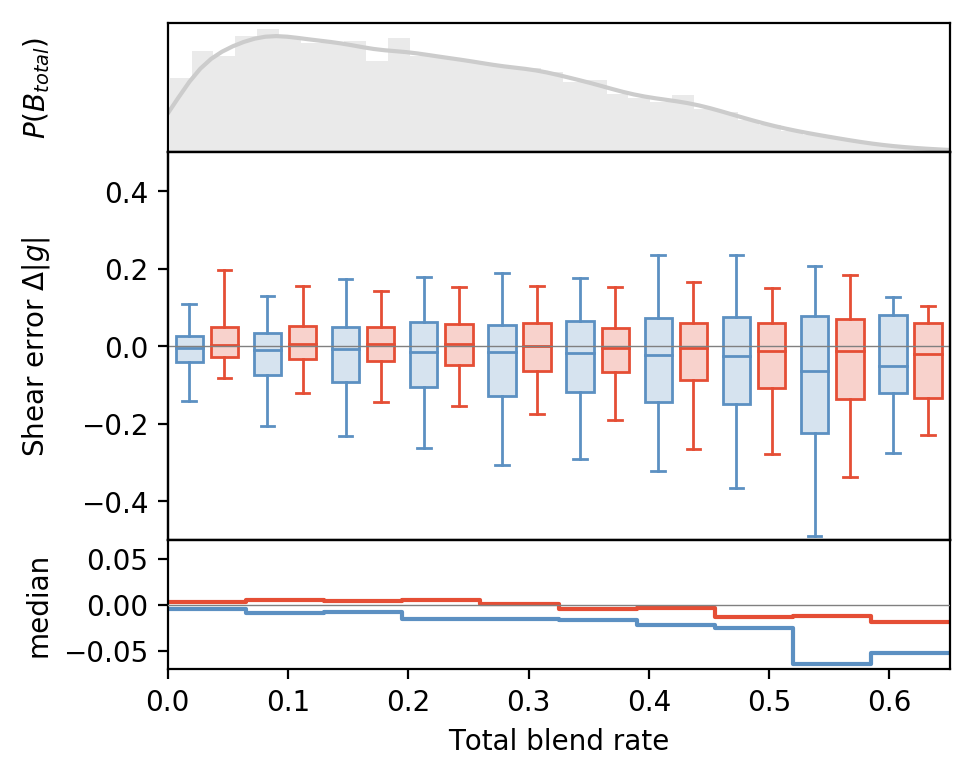

In [100]:
fig = boxplot(df_plot, x = 'blendedness_total_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.65),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Total blend rate', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_{total})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_b_tot_2.pdf')

#### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


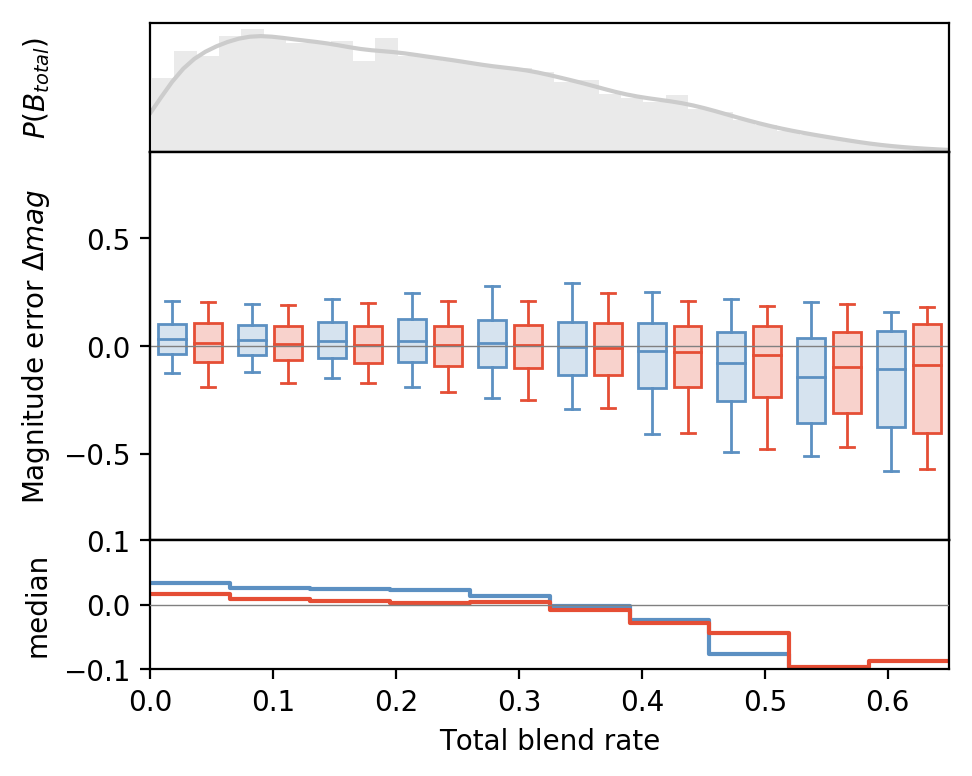

In [101]:
fig = boxplot(df_plot, x = 'blendedness_total_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., .65),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Total blend rate', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{total})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_tot_2.pdf')

## As a function of aperture blending fraction

### Error on ellipticity

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


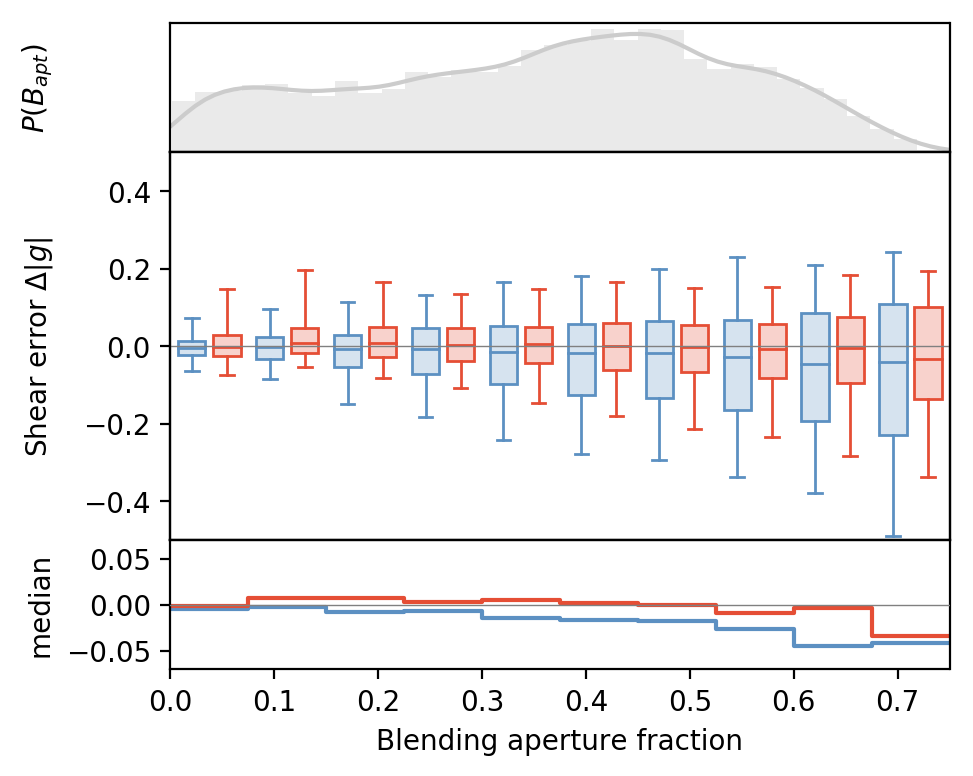

In [102]:
fig = boxplot(df_plot, x = 'blendedness_aperture_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.75),
              ylim = (-0.5,0.5),
              ylim2 = (-0.07,0.07),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blending aperture fraction', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_{apt})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_b_apt_2.pdf')

### Error on magnitude

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


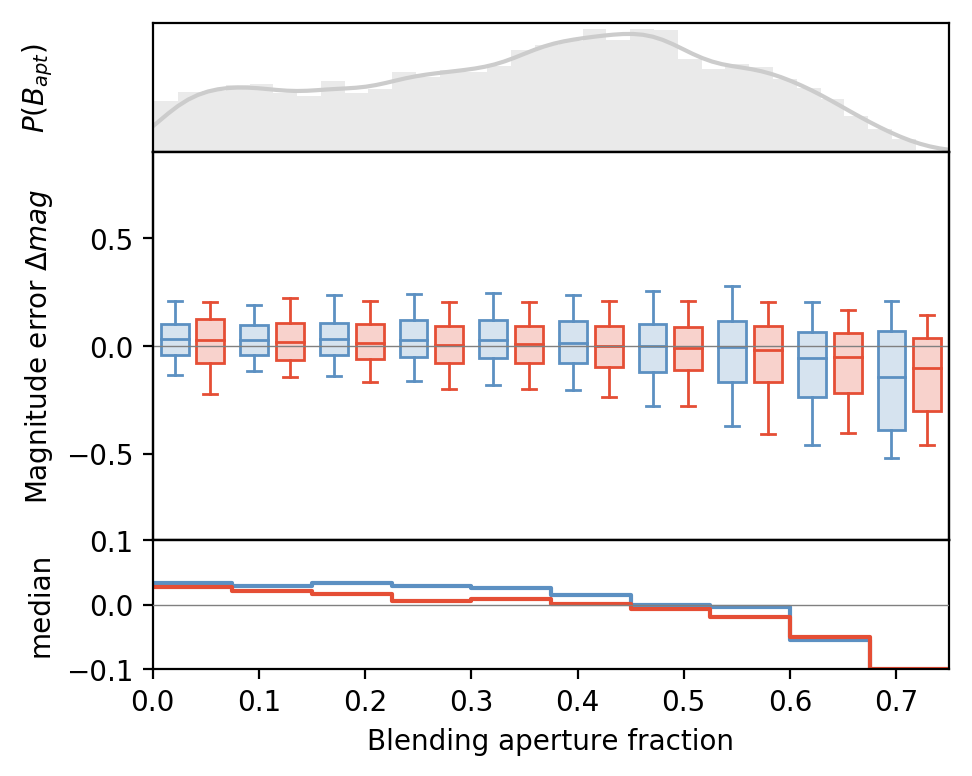

In [103]:
fig = boxplot(df_plot, x = 'blendedness_aperture_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., .75),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blending aperture fraction', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{apt})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_apt_2.pdf')

## As a function of delta magnitude

### Error on ellipticity

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


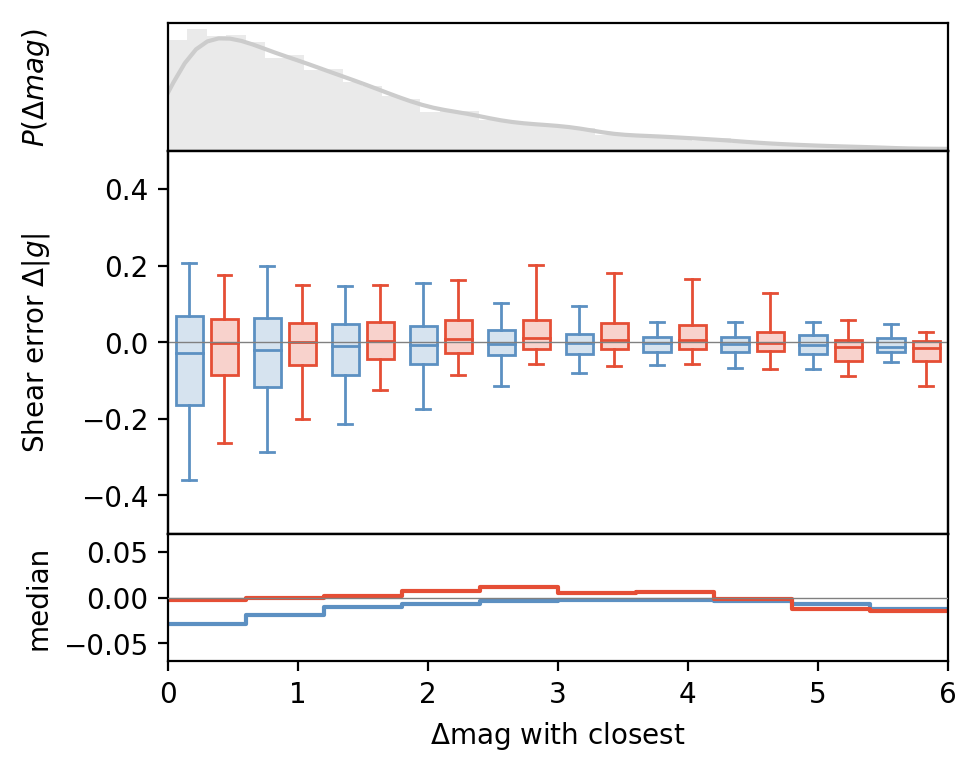

In [104]:
fig = boxplot(df_plot, x = 'delta_mag_closest', y = 'e_error', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_mag_c_2.pdf')

### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


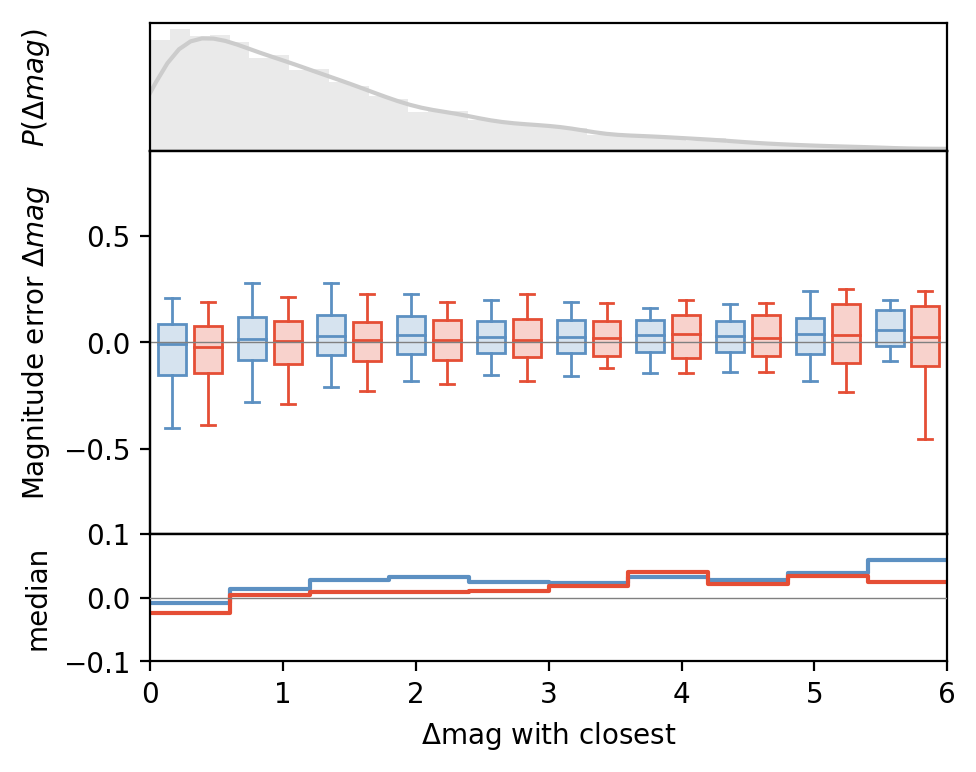

In [105]:
fig = boxplot(df_plot, x = 'delta_mag_closest', y = 'mag_error', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_mag_c_2.pdf')

# N sampling for the same galaxy on few blended images

In [112]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [113]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [114]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [115]:
list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)

NameError: name 'batch_gen_lsst_euclid' is not defined

In [ ]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

flux_out_lsst = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst_euclid = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
input_noiseless = []
input_noisy = []
output_deblender = []
output_deblender_lsst_euclid = []
blend_rate = []
nb_of_gal = []
err_count = 0

# Measurement of fluxes
mask = plot.createCircularMask(stamp_size,stamp_size,None,5)


for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    input_noiseless.append(denorm(list_galsim_simple[1], bands_lsst_euclid, channel_last = True))
    
    plt.imshow(list_galsim_simple[0][0][:,:,2])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    #try: 
    print(i)
    for j in range (nb_of_samplings):
        print(j)
        output_vae_list_lsst = deblender_lsst.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
        output_vae_list_lsst = denorm (output_vae_list_lsst, bands_lsst, channel_last = True)
        
        output_vae_list_lsst_euclid = deblender_lsst_euclid.predict(list_galsim_simple[0][:,:,:], batch_size = batch_size)
        output_vae_list_lsst_euclid = denorm (output_vae_list_lsst_euclid, bands_lsst_euclid, channel_last = True)
        
        if j == (nb_of_samplings-1) :  
            input_noisy.append(denorm(list_galsim_simple[0], bands_lsst_euclid, channel_last = True))
            output_deblender.append(output_vae_list_lsst)
            output_deblender_lsst_euclid.append(output_vae_list_lsst_euclid)
            blend_rate.append(list_galsim_simple[7][0])
            nb_of_gal.append(len(list_galsim_simple[5]))

        for t in range (batch_size):
            img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,2])
            res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
            res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst[t,:,:,2].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst[i,j*batch_size+t] = np.sum(masked_img_in_simple)

            img_out_simple_euclid = galsim.Image(output_vae_list_lsst_euclid[t][:,:,6])
            res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e1
            res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e2
            res_out_lsst_euclid_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst_euclid[t,:,:,6].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst_euclid[i,j*batch_size+t] = np.sum(masked_img_in_simple)

    #except :
    #    err_count +=1
    #    print('erreur')
    #    pass
    #continue
            
print(err_count)

In [34]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')
flux_in = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(input_noiseless[k][0][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    masked_img_in_simple = input_noiseless[k][0][:,:,6].copy()
    masked_img_in_simple[~mask] = 0  
    flux_in[k] = np.sum(masked_img_in_simple)

    print(res_in_e1[k], res_in_e2[k])

0.0015546844 0.0059353914
0.24678348 0.26398543
-0.22094715 0.34989557


[]

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


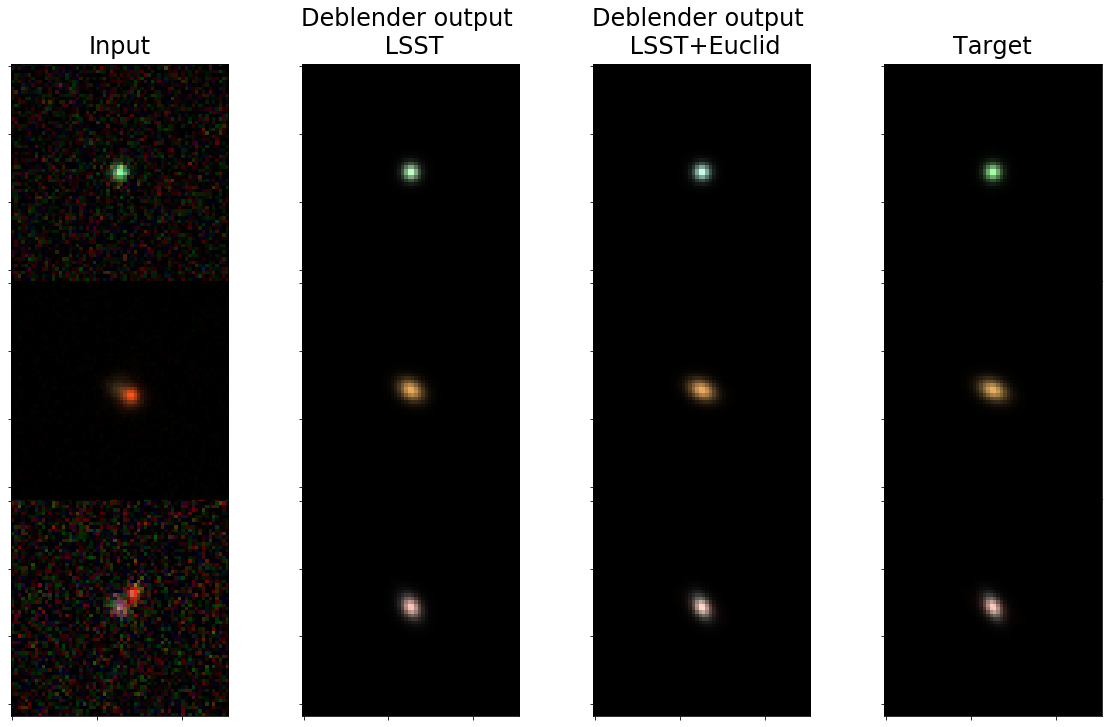

In [35]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))



####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Input', pad = 10)

ax = axes[0,1]
plot_rgb_lsst(np.mean(output_deblender[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST', pad = 10)

ax = axes[0,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST+Euclid', pad = 10)

ax = axes[0,3]
plot_rgb_lsst_euclid(input_noiseless[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Target', pad = 10)


####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
plot_rgb_lsst(np.mean(output_deblender[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,3]
plot_rgb_lsst_euclid(input_noiseless[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
plot_rgb_lsst(np.mean(output_deblender[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,3]
plot_rgb_lsst_euclid(input_noiseless[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

In [36]:
blend_rate

[array([], dtype=float64),
 array([0.53614187, 0.27017361, 0.28062558]),
 array([0.10091618])]

0.16652507 0.3


Text(0.5, 0, 'total flux in - total flux out / \n total flux in')

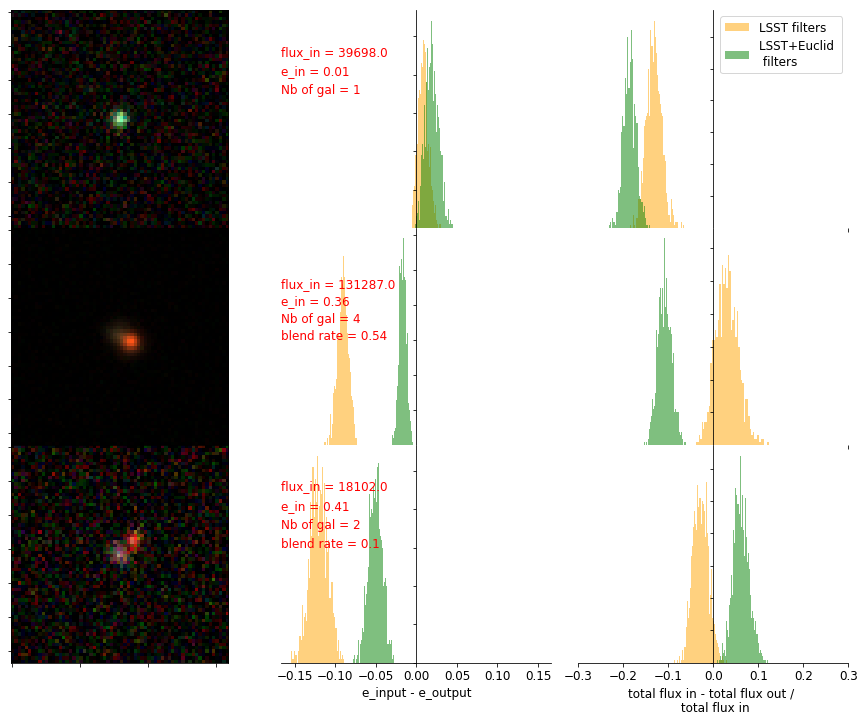

In [37]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))

max_x = np.max(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
min_x = np.min(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
max_lim_flux = 0.3# np.max((np.abs(max_x), np.abs(min_x)))

print(max_lim, max_lim_flux)
####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('Input', pad = 10)

ax = axes[0,1]
ax.hist(res_out_lsst_e[0]- res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[0]- res_in_e[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[0])+1, 0)), fontsize =12, color='r')
if len(blend_rate[0])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[0]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)

ax = axes[0,2]
ax.hist((flux_out_lsst[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.legend()
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)



####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
ax.hist(res_out_lsst_e[1]- res_in_e[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[1]- res_in_e[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color ='green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[1])+1, 0)), fontsize =12, color='r')
if len(blend_rate[1])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[1]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
ax.hist((flux_out_lsst[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
ax.hist(res_out_lsst_e[2]-res_in_e[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[2]- res_in_e[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[2])+1, 0)), fontsize =12, color='r')
if len(blend_rate[2])!=0:
       ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[2]), 2)), fontsize =12, color='r')

ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('e_input - e_output')


ax = axes[2,2]
ax.hist((flux_out_lsst[2]-flux_in[2])/flux_in[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('total flux in - total flux out / \n total flux in')
